<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/kiemtra_sklearn_code7_model_M1_predict_org_outliers_minmax_scaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P0. Các thư viện phổ biến

In [295]:
!pip install sklearn --q
# !pip install metrics --q

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as KK
from tensorflow.keras import backend as K
import math
from sklearn.metrics import r2_score
# from tensorflow.keras.metrics import RootMeanSquaredError as RMSE
# import metrics
from scipy.stats import pearsonr


In [297]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/hybrid_model')
outs=['fig','tab']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [298]:
# import numpy
def R2_SCORES(actual,predict):
  # actual = [1,2,3,4,5]
  # predict = [1,2.5,3,4.9,4.9]
  
  corr_matrix = np.corrcoef(actual, predict)
  corr = corr_matrix[0,1]
  R_sq = corr**2
  
  # print(R_sq)
  return R_sq
R2_SCORES([1,2,3,4,5],[1,2.5,3,4.9,4.9])

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
#               metrics =["accuracy"])

# P1. Mô tả mô hình

Mô hình này dùng 3 số liệu quá khứ để dự báo cho cho một giá trị tương lai

Ví dụ 1 2 3 sẽ dự báo cho 4

Chạy dự báo cho trường hợp đơn giản là chuỗi liên tục 1-432

Đánh giá kết quả tốt cho số liệu giả định trước khi dùng mô hình trên cho số liệu thực

# P2. Xây dựng mô hình cho số liệu giả định

In [299]:
import matplotlib.pyplot as plt
import numpy as np


# Fs = 432
# f = 36
# sample = 432
# x = np.arange(sample)
# y = np.cos(2 * np.pi * f * x / Fs)
# plt.plot(x[0:36], y[0:36])
# plt.xlabel('sample(n)')
# plt.ylabel('voltage(V)')
# plt.show()

In [300]:
# import random
# y_nhieu=[]
# nhieu=[]
# for k in range(len(y)):
#   nhieu.append(random.random())
#   y_nhieu.append(y[k]+random.random())

# NDI
url_outliers="https://docs.google.com/spreadsheets/d/e/2PACX-1vS7M_PbPc83Q82fuYaTRkGWua5PVj5mwrZLByQtqbAXJ3IaZ_w2MpoypIHPAu49srCajW4SPBPLTR57/pub?output=csv"
# df=pd.read_csv(url_outliers,header=0)
# url_seasonal_outliers="https://docs.google.com/spreadsheets/d/e/2PACX-1vSnamI-o2lSOYKIqv7y6ujsr3WTkxGB---cdQG5JdrQjZPJ7rSXda5UkEhZNl1jaeHxSVpyiw_rFlpt/pub?output=csv"	
# url_seasonal="https://docs.google.com/spreadsheets/d/e/2PACX-1vS0Ms5D4VCnUjXmQARhcrEQEFCFLPhyQIgJeZkC3o_U0PHaJvg_B3hNT1YqgdFQqhcYQ650u3P8RmPa/pub?output=csv"
df=pd.read_csv(url_outliers,header=0)

# url_trend="https://docs.google.com/spreadsheets/d/e/2PACX-1vQ224712F-sBcr_yi97BoMRhq4wexXnE1H8AlfYmW9aghKxjVI3GnnPBZXLIetN0KvLy10bxmD8hj9D/pub?output=csv"	
# df=pd.read_csv(url_trend,header=0)
print(df.head())
# quay dau no lai
# df1=df.iloc[::-1]
# # print(df.tail())
# df2=df1.interpolate()
# # print(df2.tail())
# df3=df2.iloc[::-1]
# # print(df3.head())
# # NDI=df3['org'].values
# # pandas series
# d = pd.Series(df3['org'].values)

# # print"Series...\n",d

# # # interpolate
# # d.interpolate(method='polynomial', order=2)
# df.isna().sum()
# # df.interpolate()
# meanVal = df['org'].mean()
# df['org'].fillna(value=meanVal, inplace=True)
# print(df.isna().sum())
NDI=df['removed_outliers'].values

   Unnamed: 0  original  removed_outliers
0  1981-01-01      0.90              0.90
1  1981-02-01     -0.62             -0.62
2  1981-03-01     -0.31             -0.31
3  1981-04-01     -0.40             -0.40
4  1981-05-01      0.31              0.31


## số liệu đầu vào

In [301]:
# dataset=np.array(range(0,432))
# dataset=np.array(y_nhieu)
# dataset=y
dataset=NDI
# dataset=np.array(nhieu)
vector_date=pd.date_range(start='1981-01',end='2016-12',freq='MS')
# vector_date.shape

Text(0.5, 1.0, 'testing')

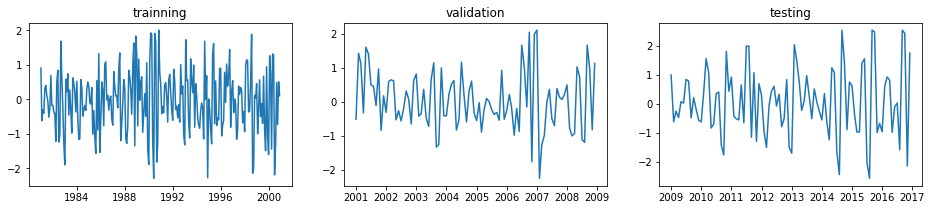

In [302]:
# plot training, validate, testing
fig,ax=plt.subplots(figsize=(16,3))
plt.subplot(131)
plt.plot(vector_date[:20*12],dataset[0:20*12])
plt.title('trainning')
plt.subplot(132)
plt.plot(vector_date[20*12:28*12],dataset[20*12:28*12])
plt.title('validation')
plt.subplot(133)
plt.plot(vector_date[28*12:],dataset[28*12:])
plt.title('testing')

## Scaled data theo trainning

In [303]:
train, validate, test=dataset[:20*12],dataset[20*12:28*12],dataset[28*12:]
train_min, train_max,train_mean,train_std=np.min(train),np.max(train),np.mean(train),np.std(train)
train_01,train_nor=(train-train_min)/(train_max-train_min),(train-train_mean)/train_std
# validate scale
validate_01,validate_nor=(validate-train_min)/(train_max-train_min),(validate-train_mean)/train_std
# test scale
test_01,test_nor=(test-train_min)/(train_max-train_min),(test-train_mean)/train_std

Text(0.5, 1.0, 'normality scale')

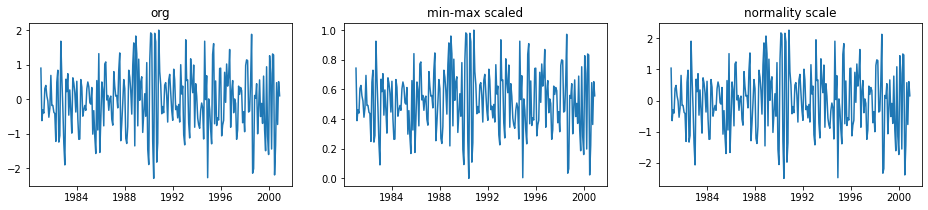

In [304]:
# plot org, min-max, normality training
fig,ax=plt.subplots(figsize=(16,3))
plt.subplot(131)
plt.plot(vector_date[:20*12],train)
plt.title('org')
plt.subplot(132)
plt.plot(vector_date[:20*12],train_01)
plt.title('min-max scaled')
plt.subplot(133)
plt.plot(vector_date[:20*12],train_nor)
plt.title('normality scale')

Text(0.5, 1.0, 'normality scale')

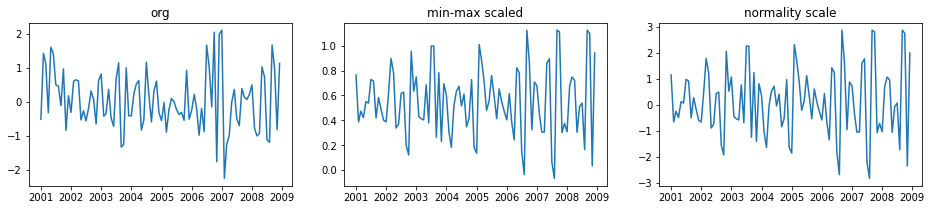

In [305]:
# plot org, min-max, normality training
fig,ax=plt.subplots(figsize=(16,3))
plt.subplot(131)
plt.plot(vector_date[20*12:28*12],validate)
plt.title('org')
plt.subplot(132)
plt.plot(vector_date[20*12:28*12],test_01)
plt.title('min-max scaled')
plt.subplot(133)
plt.plot(vector_date[20*12:28*12],test_nor)
plt.title('normality scale')

Giá trị scaled theo training của validate sẽ không nằm trong phạm vi 0-1, mean của validate_nor cũng không bằng 0

Không được scale trước vì toàn bộ dữ liệu testing sẽ ảnh hưởng đến quá trình training.

Nó vi phạm cái gọi là leaking data

# Tranform data bang thu vien

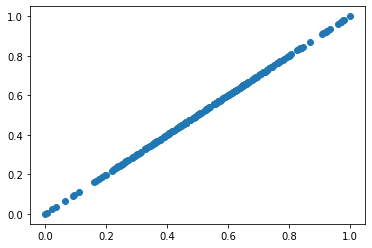

In [306]:
 train, validate, test=dataset[:20*12],dataset[20*12:28*12],dataset[28*12:]
 from sklearn import preprocessing
#  sc=preprocessing.MinMaxScaler(0,1)

min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler = preprocessing.StandardScaler()
train_01_new = min_max_scaler.fit_transform(train.reshape(train.shape[0],1))
# plt.scatter(train_01_new,train_01)
plt.scatter(train_01_new,train_01)
# RMSE(np.array(train_01_new),np.array(train_01_new))

array([[ 0.00000000e+00, -4.52214452e-01, -3.82284382e-01, ...,
        -3.49650350e-01,  7.22610723e-02, -3.82284382e-01],
       [ 4.52214452e-01, -1.11022302e-16,  6.99300699e-02, ...,
         1.02564103e-01,  5.24475524e-01,  6.99300699e-02],
       [ 3.82284382e-01, -6.99300699e-02,  0.00000000e+00, ...,
         3.26340326e-02,  4.54545455e-01,  0.00000000e+00],
       ...,
       [ 3.49650350e-01, -1.02564103e-01, -3.26340326e-02, ...,
         1.11022302e-16,  4.21911422e-01, -3.26340326e-02],
       [-7.22610723e-02, -5.24475524e-01, -4.54545455e-01, ...,
        -4.21911422e-01,  5.55111512e-17, -4.54545455e-01],
       [ 3.82284382e-01, -6.99300699e-02,  0.00000000e+00, ...,
         3.26340326e-02,  4.54545455e-01,  0.00000000e+00]])

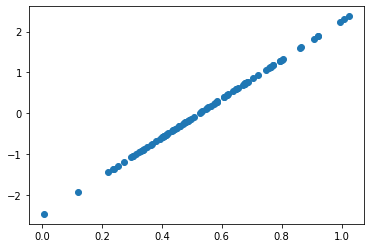

In [307]:
# fit validate_01
validate_01_new=min_max_scaler.transform(validate.reshape(validate.shape[0],1))
plt.scatter(validate_01_new,validate_nor)

validate_01_new-validate_01

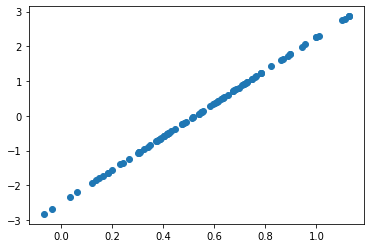

In [308]:
# fit validate_01
test_01_new=min_max_scaler.transform(test.reshape(test.shape[0],1))
plt.scatter(test_01_new,test_nor)

# Invert scale test

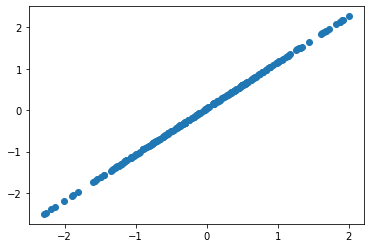

In [309]:
train_01_new_rescaled=min_max_scaler.inverse_transform(train_01_new)
plt.scatter(train_01_new_rescaled,train_nor)


## Chuyển dữ liệu sang dạng suppervised 3-1

In [310]:

def to_supervised(train, n_input, n_out):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[1]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end:out_end, 0])
  # move along one time step
    in_start += 1
  return np.array(X), np.array(y)

In [311]:
# kiem tra function
test_function_data=np.array(np.arange(10))
test_fn_data=test_function_data.reshape(test_function_data.shape[0],1)
test_fn_data.shape

XX,YY=to_supervised(train=test_fn_data,n_input=36,n_out=1)
XX.shape,YY.shape
print(XX)
print(YY)

[]
[]


In [312]:
# chuyen train ve array 2 mang
# train_nor_2ar=train_nor.reshape(train.shape[0],1)
# train_nor_2ar=train.reshape(train.shape[0],1)
train_01_2ar=train_01.reshape(train_01_new.shape[0],1)
n_input0,n_out0=36,1
# train_x, train_y = to_supervised(train=train_nor_2ar,n_input=n_input0,n_out=n_out0)
train_x, train_y = to_supervised(train=train_01_2ar,n_input=n_input0,n_out=n_out0)
train_x.shape,train_y.shape

# chuyen val ve array 2 mang

# validate_nor_2ar=validate_nor.reshape(validate_nor.shape[0],1)
# validate_nor_2ar=validate.reshape(validate.shape[0],1)
validate_01_2ar=validate_01_new.reshape(validate_01.shape[0],1)
# n_input0,n_out0=3,1
# validate_x, validate_y = to_supervised(train=validate_nor_2ar,n_input=n_input0,n_out=n_out0)
validate_x, validate_y = to_supervised(train=validate_01_2ar,n_input=n_input0,n_out=n_out0)
validate_x.shape,validate_y.shape

# chuyen val ve array 2 mang

# test_nor_2ar=test_nor.reshape(test_nor.shape[0],1)
# test_nor_2ar=test.reshape(test.shape[0],1)
test_01_2ar=test_01_new.reshape(test_01.shape[0],1)
# n_input0,n_out0=3,1
# test_x, test_y = to_supervised(train=test_nor_2ar,n_input=n_input0,n_out=n_out0)
test_x, test_y = to_supervised(train=test_01_2ar,n_input=n_input0,n_out=n_out0)
test_x.shape,test_y.shape

((59, 36, 1), (59, 1))

In [313]:
# org
# train_nor[0:8]

In [314]:
# kiem tra gia 5 tri dau tien
train_x[0:5,:]

array([[[0.74358974],
        [0.38927739],
        [0.46153846],
        [0.44055944],
        [0.60606061],
        [0.62703963],
        [0.55710956],
        [0.52214452],
        [0.41258741],
        [0.47319347],
        [0.69463869],
        [0.49184149],
        [0.49184149],
        [0.44522145],
        [0.43822844],
        [0.24941725],
        [0.64801865],
        [0.72960373],
        [0.24475524],
        [0.28904429],
        [0.92540793],
        [0.67832168],
        [0.47552448],
        [0.23543124],
        [0.09090909],
        [0.66899767],
        [0.58508159],
        [0.70629371],
        [0.42657343],
        [0.5967366 ],
        [0.46153846],
        [0.30536131],
        [0.67832168],
        [0.64335664],
        [0.57808858],
        [0.44755245]],

       [[0.38927739],
        [0.46153846],
        [0.44055944],
        [0.60606061],
        [0.62703963],
        [0.55710956],
        [0.52214452],
        [0.41258741],
        [0.47319347],
        

In [315]:
train_y[0:5,:]

array([[0.65501166],
       [0.4009324 ],
       [0.26340326],
       [0.26573427],
       [0.66666667]])

## xây dựng các functions

In [316]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

from sklearn.metrics import mean_squared_error

# huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

In [317]:
# activate function
# Custom activation function
from keras.layers import Activation
from tensorflow.keras import backend as K
from keras.utils.generic_utils import get_custom_objects



def custom_activation(x):
    return (K.tanh(x) * 3) 

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [318]:
# layer = tf.keras.layers.LeakyReLU()
# output = layer([-3.0, -1.0, 0.0, 2.0])
# list(output.numpy())

# layer = tf.keras.layers.LeakyReLU(alpha=0.01)
# output = layer([-3,-2,0,1, 2, 3])
# list(output.numpy())


In [319]:
## nhap cac thu vien can thiet
from keras import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping


## Cac thong so mo hinh

In [320]:
# K.clear_session()
# optimization
number_units0=96
number_epochs0=800
number_batch0=32
learing_rate0=0.001
# activation_function0='custom_activation'
# activation_function0=activations.relu
# activation_function0=activations.linear
# activation_function0=activations.tanh
activation_function0=activations.sigmoid
dropout0=0
patience0=20
optimizer_function0=optimizers.Adam(learing_rate0,amsgrad=False)
# loss0=tf.keras.losses.MeanAbsolutePercentageError()
# loss0=tf.keras.losses.MeanSquaredError()
# loss0=tf.keras.losses.MeanAbsoluteError()  
loss0=root_mean_squared_error


In [321]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# dinh nghia mô hình
KK.clear_session()
model=Sequential()
model.add(LSTM(number_units0, input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True))
model.add(LSTM(number_units0,return_sequences=True))
# model.add(LSTM(number_units0,return_sequences=True))
# model.add(LSTM(number_units0,return_sequences=True))
model.add(LSTM(number_units0))
model.add(Dropout(dropout0))
# model.add(TimeDistributed(Dense(268)))

# model.add(Dense(1,activation= activation_function0))
model.add(layers.Dense(1))
model.add(layers.Activation(activation_function0))
# tf.keras.layers.LeakyReLU(alpha=0.3) # dung leakyRelu

model.compile(loss=loss0, optimizer=optimizer_function0)
print(model.summary())

# Training networks
# callbacks_stop = [EarlyStopping(monitor='val_loss', patience=patience,min_delta=0)]
# callbacks_stop = [EarlyStopping(monitor='val_loss', patience=patience0)]
# fit network using ES
# history = model.fit(train_x, train_y, epochs=number_epochs0, batch_size=number_batch0, validation_data=(validate_x, validate_y),
#                 verbose=2, shuffle=False,callbacks=callbacks_stop)

history = model.fit(train_x, train_y, epochs=number_epochs0, batch_size=number_batch0, validation_data=(validate_x, validate_y),
                verbose=2, shuffle=False)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 96)            37632     
_________________________________________________________________
lstm_1 (LSTM)                (None, 36, 96)            74112     
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 185,953
Trainable params: 185,953
Non-trainable params: 0
__________________________________________________

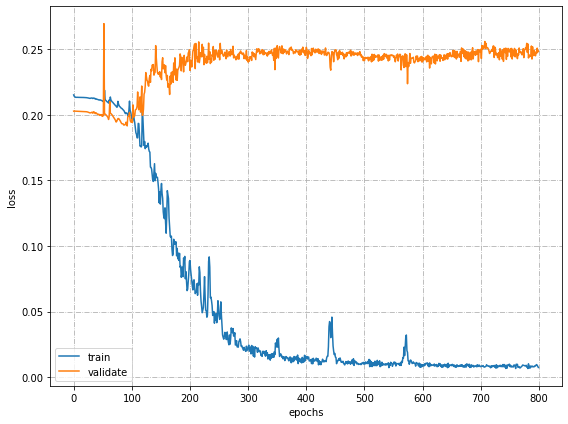

In [322]:
#  plot history
fig1=plt.Figure()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train')
ax=plt.plot(history.history['val_loss'], label='validate')
plt.grid(True,linestyle='-.')
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.title("loss at "+list1[k])
plt.legend()
plt.tight_layout()
# plt.savefig(output_fig+"/"+list1[k]+str(lt)+"n_out_"+str(n_out)+"loss"+".png",dpi=300)

# Check training

In [323]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


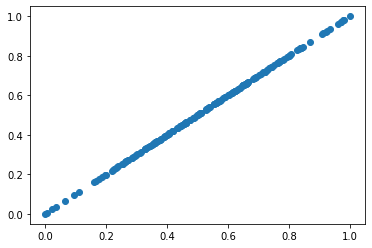

In [324]:
y_train_hat = model.predict(train_x)
y_train_hat.shape
train_y.shape
# tra lai scale ban dau
# y_validate_hat_rescaled=y_validate_hat*train_std+train_mean
# validate_y_rescaled=validate_y*train_std+train_mean

# y_train_hat_rescaled=y_train_hat
# train_y_rescaled=train_y

# y_train_hat_rescaled=y_train_hat*(train_max-train_min)+train_min
# y_train_hat_rescaled=min_max_scaler.inverse_transform(y_train_hat)
y_train_hat_rescaled=y_train_hat
# y_train_hat_rescaled=y_train_hat_rescaled*15+2
# train_y_rescaled=train_y*(train_max-train_min)+train_min
# train_y_rescaled=min_max_scaler.inverse_transform(train_y)
train_y_rescaled=train_y
# check rescaled correct
plt.scatter(train_y_rescaled,train_y)

# # Rescaled bang thu vien
# y_train_hat_rescaled=min_max_scaler.inverse_transform(y_train_hat)
# train_y_rescaled=min_max_scaler.inverse_transform(train_y)

RMSE: 0.01
CC: 1.0
MAPE: inf%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


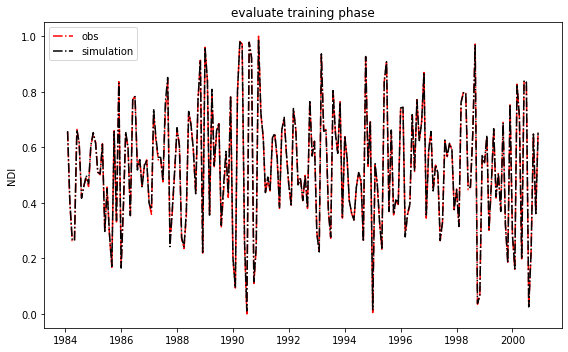

In [325]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(vector_date[n_input0+1:20*12],train_y_rescaled,'r-.')
plt.plot(vector_date[n_input0+1:20*12],y_train_hat_rescaled,'k-.')
plt.legend(['obs','simulation'])
plt.ylabel('NDI')
plt.title('evaluate training phase')
plt.tight_layout()
plt.savefig(outs[0]+'/'+'M1_trainning'+'.jpeg')
res_train=pd.DataFrame({'obs':train_y_rescaled.flatten(),'simulation':y_train_hat_rescaled.flatten()},index=vector_date[n_input0+1:20*12])
res_train.to_csv(outs[1]+'/'+'M1_trainning'+'.csv')
# tinh sai so luon

rmse = np.sqrt(mean_squared_error(train_y_rescaled, y_train_hat_rescaled))
mape=mean_absolute_percentage_error(train_y_rescaled, y_train_hat_rescaled)
rmse_train=np.sqrt(mean_squared_error(train_y_rescaled, y_train_hat_rescaled))
cc_train= r2_score(train_y_rescaled, y_train_hat_rescaled)
# cc_train= R2_SCORES(train_y_rescaled, y_train_hat_rescaled)
print("RMSE: " +str(round(rmse_train,2)))
print("CC: " +str(round(cc_train,2)))
print("MAPE: " +str(round(mape,2))+"%")

## Check validation

In [326]:
y_validate_hat = model.predict(validate_x)
y_validate_hat.shape
validate_y.shape
# tra lai scale ban dau
# y_validate_hat_rescaled=y_validate_hat*train_std+train_mean
# validate_y_rescaled=validate_y*train_std+train_mean

# y_validate_hat_rescaled=y_validate_hat
# validate_y_rescaled=validate_y
# y_validate_hat_rescaled=y_validate_hat*(train_max-train_min)+train_min
y_validate_hat_rescaled=min_max_scaler.inverse_transform(y_validate_hat)
# y_validate_hat_rescaled=y_validate_hat_rescaled*15+2
# validate_y_rescaled=validate_y*(train_max-train_min)+train_min
validate_y_rescaled=min_max_scaler.inverse_transform(validate_y)

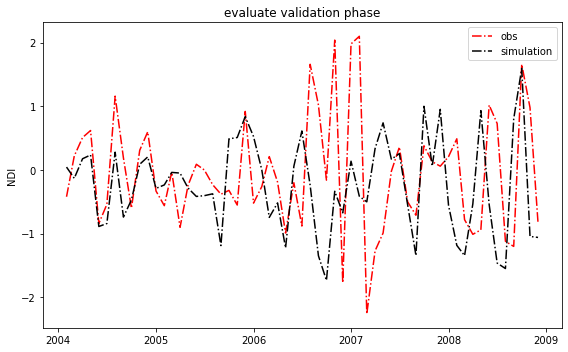

RMSE: 1.11
CC: -0.49
MAPE: inf%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [327]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(vector_date[20*12+n_input0+1:28*12],validate_y_rescaled,'r-.')
plt.plot(vector_date[20*12+n_input0+1:28*12],y_validate_hat_rescaled,'k-.')
plt.legend(['obs','simulation'])
plt.ylabel('NDI')
plt.title('evaluate validation phase')
plt.tight_layout()
plt.savefig(outs[0]+'/'+'M1_validation'+'.jpeg')
plt.show()
plt.close(fig)
res_train=pd.DataFrame({'obs':validate_y_rescaled.flatten,'simulation':y_validate_hat_rescaled.flatten},index=vector_date[20*12+n_input0+1:28*12])
res_train.to_csv(outs[1]+'/'+'M1_validation'+'.csv')

# tinh sai so luon
rmse = np.sqrt(mean_squared_error(validate_y_rescaled, y_validate_hat_rescaled))
mape=mean_absolute_percentage_error(validate_y_rescaled, y_validate_hat_rescaled)

rmse_validate=np.sqrt(mean_squared_error(validate_y_rescaled, y_validate_hat_rescaled))
cc_validate= r2_score(validate_y_rescaled, y_validate_hat_rescaled)
# cc_validate= R2_SCORES(validate_y_rescaled, y_validate_hat_rescaled)
print("RMSE: " +str(round(rmse,2)))
print("CC: " +str(round(cc_validate,2)))
print("MAPE: " +str(round(mape,2))+"%")

## Check testing

In [328]:
y_test_hat = model.predict(test_x)
y_test_hat.shape
test_y.shape
# tra lai scale ban dau
# y_test_hat_rescaled=y_test_hat*train_std+train_mean
# test_y_rescaled=test_y*train_std+train_mean

# y_test_hat_rescaled=y_test_hat
# test_y_rescaled=test_y

# y_test_hat_rescaled=y_test_hat*(train_max-train_min)+train_min
y_test_hat_rescaled=min_max_scaler.inverse_transform(y_test_hat)
# y_test_hat_rescaled=y_test_hat_rescaled*15+2
# test_y_rescaled=test_y*(train_max-train_min)+train_min
test_y_rescaled=min_max_scaler.inverse_transform(test_y)

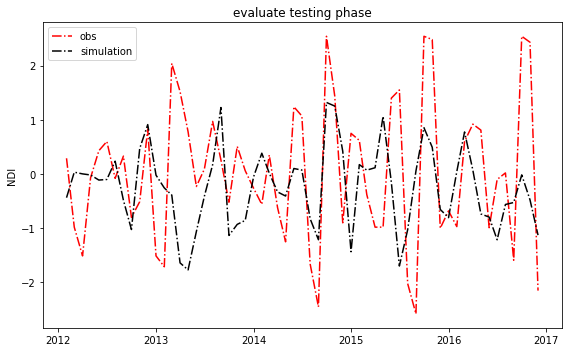

RMSE: 1.36
CC: -0.49
MAPE: 220.27%
RMSE: 1.36
MAPE: 220.27%


In [329]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(vector_date[28*12+n_input0+1:],test_y_rescaled,'r-.')
plt.plot(vector_date[28*12+n_input0+1:],y_test_hat_rescaled,'k-.')
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
plt.title('evaluate testing phase')
plt.tight_layout()
plt.savefig(outs[0]+'/'+'M1_testing'+'.jpeg')
plt.show()
plt.close(fig)
res_train=pd.DataFrame({'obs':test_y_rescaled.flatten,'simulation':y_test_hat_rescaled.flatten},index=vector_date[28*12+n_input0+1:])
res_train.to_csv(outs[1]+'/'+'M1_testing'+'.csv')
# tinh sai so luon
rmse = np.sqrt(mean_squared_error(test_y_rescaled, y_test_hat_rescaled))
mape=mean_absolute_percentage_error(test_y_rescaled, y_test_hat_rescaled)

rmse_test=np.sqrt(mean_squared_error(test_y_rescaled, y_test_hat_rescaled))
cc_test= r2_score(test_y_rescaled, y_test_hat_rescaled)
# cc_test= R2_SCORES(test_y_rescaled, y_test_hat_rescaled)
print("RMSE: " +str(round(rmse,2)))
print("CC: " +str(round(cc_validate,2)))
print("MAPE: " +str(round(mape,2))+"%")

print("RMSE: " +str(round(rmse,2)))
print("MAPE: " +str(round(mape,2))+"%")

In [330]:

df_res=pd.DataFrame({'test_obs':test_y_rescaled.flatten(),'test_pred':y_test_hat_rescaled.flatten()})
df_res.index=vector_date[28*12+n_input0+1:]
# df_res.to_csv(outs[1]+'/'+'M1_test_pred_org_outliers_minmax_scaled'+'.csv')

# Tinh sai so 

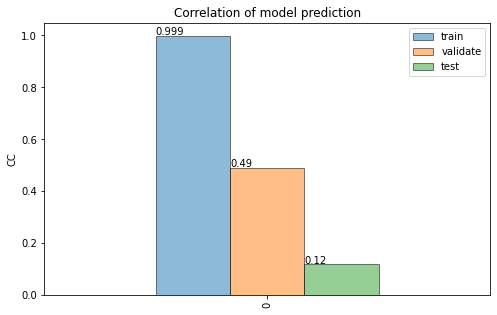

In [331]:
df_results_CC=pd.DataFrame({'train':np.abs(np.array([cc_train])),'validate':np.abs(np.array([cc_validate])),'test':np.abs(np.array([cc_test]))})

fig,ax=plt.subplots(figsize=(8,5))
# plt.subplot(111)
ax=df_results_CC.plot(kind='bar',edgecolor='k',alpha=0.5,ax=ax)
# labels = ["%0.2f" % i for i in df_results_CC.astype('float32')]
# # ax=plt.bar(x + 0.17, test_mae, width, label='Test')
# rects = ax.patches
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2, height + 0, label,
#             ha='center', va='bottom')
# plt.grid(None)
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Correlation of model prediction')
plt.ylabel('CC')
# plt.savefig(out_dir_all[0]+'/'+str(n_steps_in)+'_'+str(n_steps_out)+'correllation.png')
plt.show()
plt.close(fig)

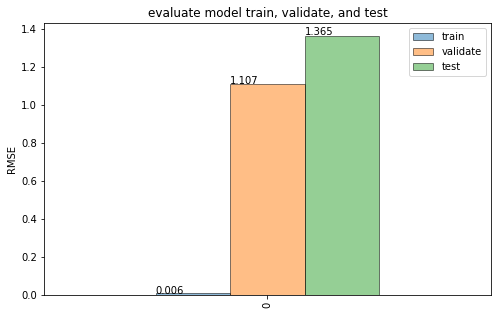

In [332]:
df_results_RMSE=pd.DataFrame({'train':np.abs(np.array([rmse_train])),'validate':np.abs(np.array([rmse_validate])),'test':np.abs(np.array([rmse_test]))})

fig,ax=plt.subplots(figsize=(8,5))
# plt.subplot(111)
ax=df_results_RMSE.plot(kind='bar',edgecolor='k',alpha=0.5,ax=ax)
# labels = ["%0.2f" % i for i in df_results_CC.astype('float32')]
# # ax=plt.bar(x + 0.17, test_mae, width, label='Test')
# rects = ax.patches
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width() / 2, height + 0, label,
#             ha='center', va='bottom')
# plt.grid(None)
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('evaluate model train, validate, and test')
plt.ylabel('RMSE')
# plt.savefig(out_dir_all[0]+'/'+str(n_steps_in)+'_'+str(n_steps_out)+'correllation.png')
plt.show()
plt.close(fig)